# Loading Perceptron

In [51]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Testing That Our Perceptron Algorithim Works

Lets run a training loop to check that our Peceptron algorithim is running as expected and will eventually achieve a loss equal to 0 on linearly separable data. First we will need to generate linearly separable data. 

In [ ]:
from matplotlib import pyplot as plt
import torch
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

# first we need to generate data

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    
    return X, y

# assign the example data to variables
X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

Now that we have generated linearly separable data, lets visualize before we begin implementing linear decision boundaries.

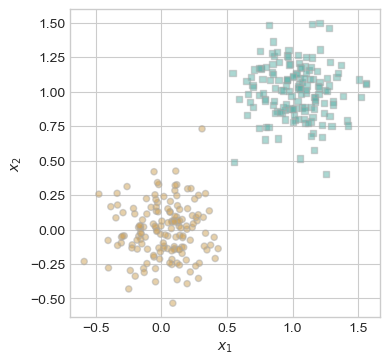

In [53]:
# Visualize our training data
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

Time to initiate our training model to test whether or not our Perceptron Algorithim can achieve a loss of 0. 

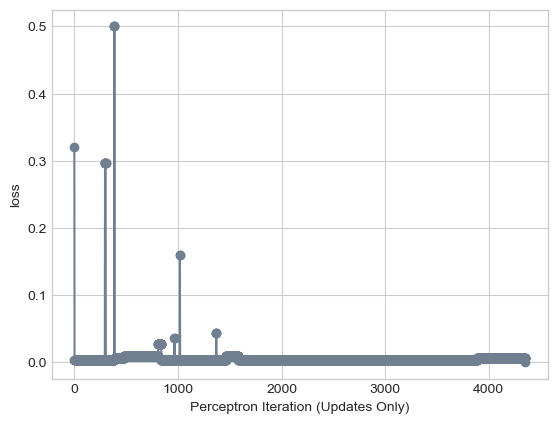

In [54]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,)).item()
    x_i = X[i].unsqueeze(0)
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Although it took a large number of iterations, our perceptron algorithim was eventually able to reach a loss of 0 and is able to identify the proper weight vector to linearly separate the data points. Lets look at our data with the final weight vector plotted.

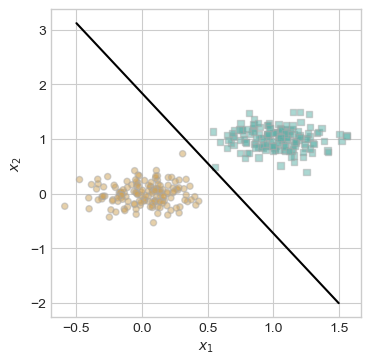

In [58]:
# define a function to plot a line
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

# plot the existing data and add a line to the graph
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

plot_perceptron_data(X, y, ax)
draw_line(p.w, -.5, 1.5, ax, color = "black")

From the visualization, we can tell that the minimization of loss 0 has correctly identified a linear line which perfectly separates the data into their correct classes. Now, let's explore the algorithim performs on data which is mathematically impossible to seprate linearly. A max iterations of 1000 will be applied to the training loop, as the algorithim will run forever without a cap. 

In [76]:
# Generate Linearly Inseparable Data
def perceptron_data_insep(n_points = 270, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # add 30 points that are the opposite class in a similar location as a previous point, thus making linearly inseparable data
    for _ in range(30):  
        rand_i = torch.randint(0, n_points, (1,))  # Pick a random point index
        x_new = X[rand_i] + torch.normal(0.0, noise, size=(1, p_dims + 1))  # Slightly modify the chosen point
        
        # flip class
        y_new = torch.tensor([1 - y[rand_i].item()])  # Convert to tensor

        X = torch.cat((X, x_new), dim=0)  # Add new point
        y = torch.cat((y, y_new), dim=0)  # Add new label

    return X, y


Now that we have generated linearly inseparable data, lets visualize before we attempt to implement a linear decision boundaries.

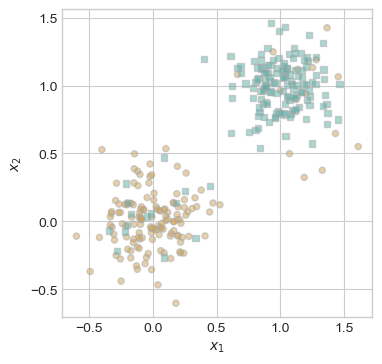

In [77]:
# Visualize our training data
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data_insep()
plot_perceptron_data(X, y, ax)

Time to initiate a training model on linearly inseparable data, with a max iterations of 1000.

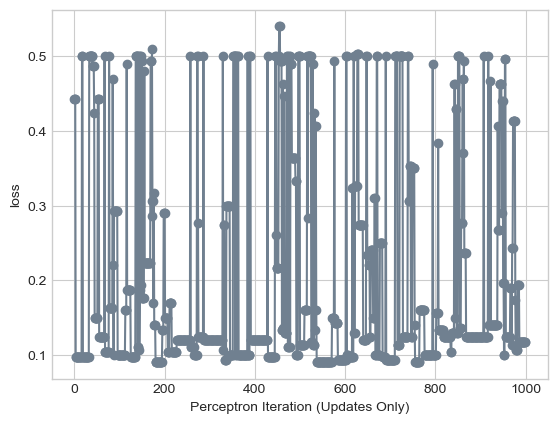

In [78]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]
iterations = 0

while loss > 0 and iterations < 1000: # terminates after 1000 iterations
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,)).item()
    x_i = X[i].unsqueeze(0)
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

    # iterate
    iterations += 1

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Compared to the linearly separable data, the algorithim has significant trouble minimizing the loss. Instead of a generally smooth curve, the loss function jumps from low to high as there is never a solution to the problem the algorithim is trying to solve. Lets look at our data with the final weight vector plotted, despite the weight vector being imperfect. 

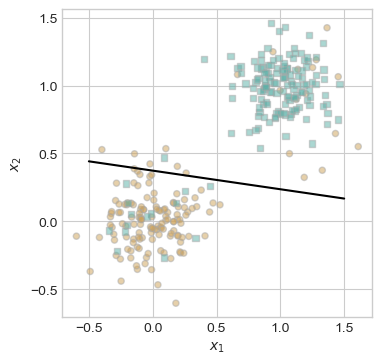

In [79]:
# plot the existing data and add a line to the graph
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

plot_perceptron_data(X, y, ax)
draw_line(p.w, -.5, 1.5, ax, color = "black")

As expected, our model is not able to perfectly differentiate between classes, as there is no linear classifier that can accomplish the task. Now lets explore how the loss function evolves on data of more than two dimenstions.

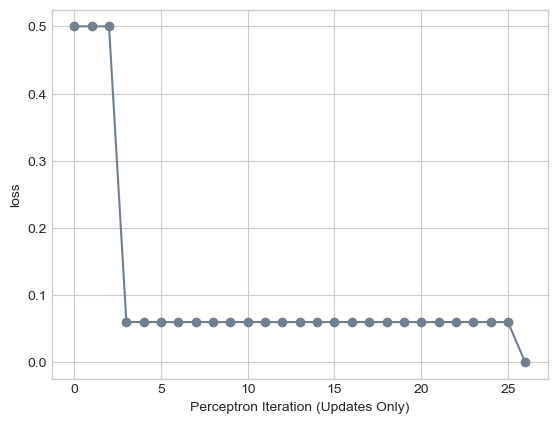

In [ ]:
# Generate data in more than 2 dimenstions
def perceptron_data5(n_points = 300, noise = 0.2, p_dims = 5):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    return X, y

X, y = perceptron_data5()

# perform the training loop
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # terminates after 1000 iterations
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,)).item()
    x_i = X[i].unsqueeze(0)
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

The Perceptron Algorithim is able to work extremely quickly to reduce the loss to 0, even on data with dimensionality greater than 2. 